<a href="https://colab.research.google.com/github/kim1987/aiffel/blob/main/aiffel/deeper/dp_ten.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GD_10  
https://pytorch.org/tutorials/beginner/translation_transformer.html

In [1]:
!wget https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
!wget https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.test.tar.gz
!wget https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.dev.tar.gz

--2022-01-05 05:57:23--  https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz [following]
--2022-01-05 05:57:23--  https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8718893 (8.3M) [application/octet-stream]
Saving to: ‘korean-english-park.train.tar.gz’

korean-eng

In [2]:
!mkdir data
!tar -zxvf ./korean-english-park.dev.tar.gz -C ./data
!tar -zxvf ./korean-english-park.test.tar.gz -C ./data
!tar -zxvf ./korean-english-park.train.tar.gz -C ./data

korean-english-park.dev.en
korean-english-park.dev.ko
korean-english-park.test.en
korean-english-park.test.ko
korean-english-park.train.en
korean-english-park.train.ko


In [3]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 14.4 MB/s 


In [4]:
!pip install transformers

     |████████████████████████████████| 3.4 MB 14.1 MB/s 
     |████████████████████████████████| 3.3 MB 53.1 MB/s 
     |████████████████████████████████| 596 kB 71.3 MB/s 
     |████████████████████████████████| 895 kB 58.2 MB/s 
     |████████████████████████████████| 61 kB 519 kB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [5]:
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-hbs4_owd/kobert-tokenizer_8a6f0e9e044845369c76f37215f52af2
  Running command git clone -q https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-hbs4_owd/kobert-tokenizer_8a6f0e9e044845369c76f37215f52af2
  Created wheel for kobert-tokenizer: filename=kobert_tokenizer-0.1-py3-none-any.whl size=4648 sha256=f6f4865d53dee7f1fd8be4e3ad9a5c18d8189340198013326641060e92f10539
  Stored in directory: /tmp/pip-ephem-wheel-cache-bidc2gjm/wheels/10/b4/d9/cb627bbfaefa266657b0b4e8127f7bf96d27376fa1a23897b4
Successfully built kobert-tokenizer


In [6]:
import numpy as np
import torch
import torchtext
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import torch.nn as nn
from torch import optim
import random
from tqdm.notebook import tqdm

In [7]:
from torch import Tensor
from torch.nn import Transformer
import math

In [8]:
from transformers import XLNetTokenizer
from kobert_tokenizer import KoBERTTokenizer

In [9]:
!pip install torchinfo

In [10]:
from torchinfo import summary

데이터 불러오기 및 전처리

In [11]:
txt_train_en = pd.read_fwf('/content/data/korean-english-park.train.en',header=None,names=['english'],encoding='utf-8',delimiter='\n')
txt_train_ko = pd.read_fwf('/content/data/korean-english-park.train.ko',header=None,names=['korean'],encoding='utf-8',delimiter='\n')

txt_test_en = pd.read_fwf('/content/data/korean-english-park.test.en',header=None,names=['english'],encoding='utf-8',delimiter='\n')
txt_test_ko = pd.read_fwf('/content/data/korean-english-park.test.ko',header=None,names=['korean'],encoding='utf-8',delimiter='\n')

In [12]:
txt_train = pd.concat([txt_train_ko,txt_train_en],axis=1)
txt_test = pd.concat([txt_test_ko,txt_test_en],axis=1)

In [13]:
print(txt_train.applymap(len).max(),'\n')
print(txt_test.applymap(len).max())

korean     162
english    258
dtype: int64 

korean     130
english    241
dtype: int64


In [14]:
max_len = 60

In [15]:
txt_train = txt_train[(txt_train['korean'].apply(len)<=max_len) & (txt_train['english'].apply(len)<=max_len+15)]
txt_test = txt_test[(txt_test['korean'].apply(len)<=max_len) & (txt_test['english'].apply(len)<=max_len+15)]

In [16]:
ko_tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
en_tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

Downloading:   0%|          | 0.00/363k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/244 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/432 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

In [17]:
ko_tokenizer.padding_side='right'
en_tokenizer.padding_side='right'

In [18]:
txt_train['korean']=txt_train['korean'].apply(lambda x : ko_tokenizer(x,padding = 'max_length',max_length = max_len+10))
txt_train['english']=txt_train['english'].apply(lambda x : '<s> '+x)#maxlen 을 다르게 줘도됨.
txt_train['english']=txt_train['english'].apply(lambda x : en_tokenizer(x,padding = 'max_length',max_length = max_len+30))
txt_test['korean']=txt_test['korean'].apply(lambda x : ko_tokenizer(x,padding = 'max_length',max_length = max_len+5))
txt_test['english']=txt_test['english'].apply(lambda x : '<s> '+x)
txt_test['english']=txt_test['english'].apply(lambda x : en_tokenizer(x,padding = 'max_length',max_length = max_len+30))

In [19]:
max_len = max_len+30

In [20]:
len(txt_train)

21574

In [21]:
txt_train['korean'].iloc[0]

{'input_ids': [2, 847, 7003, 4660, 2613, 7095, 2660, 2437, 7086, 518, 7096, 5398, 6371, 1868, 5664, 2872, 3859, 259, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [22]:
class MyDataSet(torch.utils.data.Dataset):

  def __init__(self,train=True):
      self.data_ko = txt_train['korean'] if train else txt_test['korean']
      self.data_en = txt_train['english'] if train else txt_test['english']

  def __len__(self):
    return len(self.data_ko)

  def __getitem__(self,idx):
    list_ko = [self.data_ko.iloc[idx]['input_ids'],self.data_ko.iloc[idx]['attention_mask']]
    list_en = [self.data_en.iloc[idx]['input_ids'],self.data_en.iloc[idx]['attention_mask']]
    return torch.tensor(list_ko[0],dtype=torch.long),torch.tensor(list_en[0],dtype=torch.long)

In [23]:
BATCH_SIZE=32

In [24]:
data_train = MyDataSet()
data_test = MyDataSet(train=False)
load_train = torch.utils.data.DataLoader(data_train,shuffle=True,batch_size=BATCH_SIZE,num_workers=2)
load_test = torch.utils.data.DataLoader(data_test,shuffle=True,batch_size=BATCH_SIZE,num_workers=2)

In [25]:
data_train[12]

(tensor([   2,  807, 5859, 5330, 3211, 7784,  888, 5760,  909, 6410, 2236, 5899,
         5049, 7199, 7828, 3060, 7178,  522, 7352, 3240,   40, 5170, 5760, 3280,
           54,    3,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1]),
 tensor([    1,   238,    55,   116,  1376,   758,  1724,   255,    40,   599,
            13,   153, 10555,   769,  2999,     9,     4,     3,     5,     5,
             5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
             5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
             5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
             5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
             5,     5,     5,     5,     5,     5,

In [26]:
next(iter(load_train))[0][0].shape

torch.Size([70])

모델 생성.  


In [27]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
  print(torch.cuda.get_device_name())

Tesla V100-SXM2-16GB


In [28]:
ko_PAD_token_id = ko_tokenizer.pad_token_id
ko_EOS_token_id = ko_tokenizer.eos_token_id
ko_BOS_token_id = ko_tokenizer.bos_token_id

en_PAD_token_id = en_tokenizer.pad_token_id
en_EOS_token_id = en_tokenizer.eos_token_id
en_BOS_token_id = en_tokenizer.bos_token_id
en_CLS_token_id = en_tokenizer.cls_token_id

In [29]:
class PositionalEncoding(nn.Module):
  def __init__(self,emb_size:int,dropout:float,maxlen:int=max_len): # emb_size:even_number
    super().__init__()
    den = torch.exp(- torch.arange(0,emb_size,2)*math.log(10000) /emb_size)
    pos = torch.arange(0,maxlen).reshape(maxlen,1)
    pos_embedding = torch.zeros((maxlen,emb_size))
    pos_embedding[:,0::2] = torch.sin(pos*den)
    pos_embedding[:,1::2] = torch.cos(pos*den)
    pos_embedding = pos_embedding.unsqueeze(-2)

    self.dropout = nn.Dropout(dropout)
    self.register_buffer('pos_embedding',pos_embedding)

  def forward(self,token_embedding:Tensor): #len * embedding
    return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0),:])

In [30]:
class TokenEmbedding(nn.Module):
  def __init__(self,vocab_size:int, emb_size):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size,emb_size)
    self.emb_size = emb_size

  def forward(self,tokens:Tensor):
    return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

In [31]:
class Seq2SeqTransformer(nn.Module):
  
  def __init__(self,num_encoder_layers:int, num_decoder_layers:int,
               emb_size:int, nhead:int,
               src_vocab_size:int, tgt_vocab_size:int,
               dim_feedforward: int = 512, dropout:float = 0.2):
    super().__init__()
    self.transformer = Transformer(d_model=emb_size,nhead=nhead,
                                   num_encoder_layers = num_encoder_layers,
                                   num_decoder_layers=num_decoder_layers,
                                   dim_feedforward=dim_feedforward,
                                   dropout=dropout)
    
    self.generator = nn.Linear(emb_size,tgt_vocab_size)
    self.src_tok_emb = TokenEmbedding(src_vocab_size,emb_size)
    self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size,emb_size)
    self.positional_encoding = PositionalEncoding(emb_size,dropout=dropout)


  def forward(self, src,tgt,src_mask,tgt_mask,
              src_padding_mask,tgt_padding_mask,memory_key_padding_mask):
    
    src_emb = self.positional_encoding(self.src_tok_emb(src))
    tgt_emb = self.positional_encoding(self.tgt_tok_emb(tgt))

    outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                              src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
    return self.generator(outs)

  def encode(self, src,src_mask):
    return self.transformer.encoder(self.positional_encoding(self.src_tok_emb(src)),src_mask)

  def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
    return self.transformer.decoder(self.positional_encoding(
                        self.tgt_tok_emb(tgt)), memory, tgt_mask)

--------------------------pytorch code-------------


학습

len,batch 의형태로 입력받음( batch,len 시 batch_first=True 가 필요함)

In [32]:
def generate_square_subsequent_mask(sz):
  mask = (torch.triu(torch.ones((sz,sz),device = device))==1).transpose(0,1)
  mask = mask.float().masked_fill(mask == 0,float('-inf')).masked_fill(mask==1,float(0.0)) # 내부에서 true,false 를 처리하긴 함.
  return mask

In [33]:
def create_mask(src,tgt):
  src_seq_len = src.shape[0]
  tgt_seq_len = tgt.shape[0]

  tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
  src_mask = torch.zeros((src_seq_len, src_seq_len),device=device).type(torch.bool)

  src_padding_mask = (src == ko_PAD_token_id).transpose(0, 1) #N,L
  tgt_padding_mask = (tgt == en_PAD_token_id).transpose(0, 1)
  return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [34]:
def train_epoch(model,optimizer,scheduler=None):
  model.train()
  losses = 0
  train_loader = torch.utils.data.DataLoader(data_train,shuffle=True,batch_size=BATCH_SIZE,num_workers=2)
  
  for src, tgt in tqdm(train_loader):
    src = src.to(device).transpose(0,1)
    tgt = tgt.to(device).transpose(0,1)#(L,N)
    tgt_input = tgt[:-1,:]

    src_mask,tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src,tgt_input)

    optimizer.zero_grad()

    logits = model(src,tgt_input,src_mask,tgt_mask,src_padding_mask,tgt_padding_mask,src_padding_mask)

    tgt_out = tgt[1:,:]
    loss = loss_fn(logits.reshape(-1,logits.shape[-1]),tgt_out.reshape(-1))
    loss.backward()

    optimizer.step()

    losses +=loss.item()
    if scheduler is not None:
      scheduler.step()
  return losses / len(train_loader)    

In [35]:
def evaluate(model):
  model.eval()
  losses = 0

  val_dataloader =  torch.utils.data.DataLoader(data_test,shuffle=True,batch_size=BATCH_SIZE,num_workers=2)
  with torch.no_grad():
    for src, tgt in tqdm(val_dataloader):
      src = src.to(device).transpose(0,1)
      tgt = tgt.to(device).transpose(0,1)

      tgt_input = tgt[:-1, :]

      src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

      logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

      tgt_out = tgt[1:, :]
      loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
      losses += loss.item()

  return losses / len(val_dataloader)

In [36]:
def greedy_decode(model,src, src_mask,max_len,start_symbol):
  src = src.to(device)
  src_mask = src_mask.to(device)

  memory = model.encode(src,src_mask)

  ys = torch.ones(1,1).fill_(start_symbol).type(torch.long).to(device)

  for i in range(max_len-1):

    memory =memory.to(device)

    tgt_mask = (generate_square_subsequent_mask(ys.size(0))).type(torch.bool).to(device)
    out = model.decode(ys, memory,tgt_mask)
    out = out.transpose(0,1)
    prob = model.generator(out[:,-1])
    _, next_word = torch.max(prob, dim=1)
    next_word = next_word.item()
    ys = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
    if next_word == en_CLS_token_id:
        break
  return ys

In [37]:
def translate(model: torch.nn.Module, src_sentence: str):
  model.eval()
  with torch.no_grad():
    src = torch.tensor(ko_tokenizer.encode(src_sentence)).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(model,  src, src_mask, max_len=num_tokens + 5, start_symbol=en_BOS_token_id).flatten()
  return "".join(en_tokenizer.decode(list(tgt_tokens.cpu().numpy()))).replace("<s>", "").replace("</s>", "").replace("<sep>", "").replace("<cls>", "")

In [41]:
SRC_VOCAB_SIZE = len(ko_tokenizer)
TGT_VOCAB_SIZE = len(en_tokenizer)
EMB_SIZE = 256
NHEAD = 8
FFN_HID_DIM = 1024
BATCH_SIZE = BATCH_SIZE
NUM_ENCODER_LAYERS = 2
NUM_DECODER_LAYERS = 2
warmup_steps = 3000


transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters(): # 필요한가?
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(device)
#transformer.load_state_dict(torch.load('/content/drive/MyDrive/models/transformers4'))
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=en_PAD_token_id)

optimizer = torch.optim.Adam(transformer.parameters(), lr=1, betas=(0.9, 0.98), eps=1e-9)

In [42]:
def my_lr(steps,EMB_SIZE=EMB_SIZE,warmup_steps=warmup_steps):
  eps=1e-9
  return math.pow(EMB_SIZE,-0.5)*min(math.pow(steps+eps,-0.5),steps*math.pow(warmup_steps+eps,-1.5))
scheduler = None  
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer,lr_lambda = my_lr)

학습 및 테스트

In [43]:
NUM_EPOCHS = 10
train_losses =[]
val_losses=[]
for epoch in range(1,NUM_EPOCHS+1):
  train_loss = train_epoch(transformer,optimizer, scheduler)
  val_loss = evaluate(transformer)
  train_losses.append(train_loss)
  val_losses.append(val_loss)
  print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}"))

  0%|          | 0/675 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 1, Train loss: 6.809, Val loss: 5.854


  0%|          | 0/675 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 2, Train loss: 3.987, Val loss: 5.405


  0%|          | 0/675 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 3, Train loss: 3.577, Val loss: 5.244


  0%|          | 0/675 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 4, Train loss: 3.305, Val loss: 5.194


  0%|          | 0/675 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 5, Train loss: 3.063, Val loss: 5.264


  0%|          | 0/675 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 6, Train loss: 2.774, Val loss: 5.287


  0%|          | 0/675 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 7, Train loss: 2.515, Val loss: 5.453


  0%|          | 0/675 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 8, Train loss: 2.299, Val loss: 5.502


  0%|          | 0/675 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 9, Train loss: 2.127, Val loss: 5.705


  0%|          | 0/675 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 10, Train loss: 1.981, Val loss: 5.810


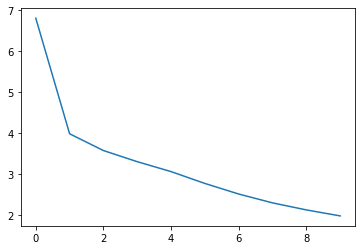

In [44]:
plt.plot(train_losses)

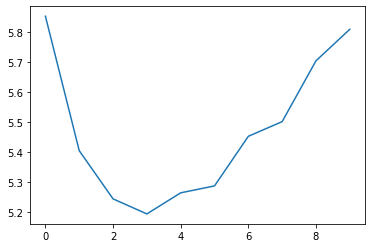

In [45]:
plt.plot(val_losses)

In [46]:
sentences = ['오바마는 대통령이다.', '시민들은 도시 속에 산다.', '커피는 필요 없다.','일곱 명의 사망자가 발생했다.']
for sen in sentences:
  print(translate(transformer,sen))

 Obama's campaign that Obama is still being held in
 The town is a growing force in a small town of southern Baghdad
 It is not clear how many people were able to help
 At least 15 people were killed.


In [47]:
NUM_EPOCHS = 10
train_losses =[]
val_losses=[]
for epoch in range(1,NUM_EPOCHS+1):
  train_loss = train_epoch(transformer,optimizer,scheduler)
  val_loss = evaluate(transformer)
  train_losses.append(train_loss)
  val_losses.append(val_loss)
  print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}"))

  0%|          | 0/675 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 1, Train loss: 1.856, Val loss: 5.917


  0%|          | 0/675 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 2, Train loss: 1.759, Val loss: 6.096


  0%|          | 0/675 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 3, Train loss: 1.673, Val loss: 6.145


  0%|          | 0/675 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 4, Train loss: 1.608, Val loss: 6.319


  0%|          | 0/675 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 5, Train loss: 1.549, Val loss: 6.439


  0%|          | 0/675 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 6, Train loss: 1.497, Val loss: 6.504


  0%|          | 0/675 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 7, Train loss: 1.438, Val loss: 6.449


  0%|          | 0/675 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 8, Train loss: 1.393, Val loss: 6.480


  0%|          | 0/675 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 9, Train loss: 1.347, Val loss: 6.592


  0%|          | 0/675 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 10, Train loss: 1.304, Val loss: 6.579


In [48]:
sentences = ['오바마는 대통령이다.', '시민들은 도시 속에 산다.', '커피는 필요 없다.','일곱 명의 사망자가 발생했다.']
for sen in sentences:
  print(translate(transformer,sen))

 Obama is on Wednesday's point.
 One of the victims have found a good chance to see old.
 It's not too soon to start thinking about traveling
 One of the dead were killed.


In [49]:
torch.save(transformer.state_dict(), '/content/drive/MyDrive/models/transformers5')

In [50]:
class MyTransformer(nn.Module):
  def __init__(self,d_model=512,nhead=8,num_encoder_layers=6,num_decoder_layers=6,
               dim_feedforward=2048,dropout=0.1,activation=nn.functional.relu,
               layer_norm_eps=1e-5):
    super().__init__()
    encoder_layer = nn.TransformerEncoderLayer(d_model,nhead,dim_feedforward,dropout,
                                         activation,layer_norm_eps)
    encoder_norm = torch.nn.LayerNorm(d_model,eps=layer_norm_eps)
    self.encoder = nn.TransformerEncoder(encoder_layer,num_encoder_layers,encoder_norm)#layer을 계속 물려줌.

    decoder_layer = nn.TransformerDecoderLayer(d_model,nhead,dim_feedforward,dropout,
                                               activation,layer_norm_eps)
    decoder_norm = nn.Layernorm(d_model,eps=layer_norm_eps)
    self.decoder = nn.TransformerDecoder(decoder_layer,num_decoder_layers,decoder_norm)

    self._reset_parameters()

    self.d_model = d_model
    self.nhead = nhead

  def forward(src,tgt,src_mask,tgt_mask,memory_mask=None,
              src_key_padding_mask=None,tgt_key_padding_mask=None,memory_key_padding_mask=None):#L,N,E
    memory = self.encoder(src,mask=src_mask,src_key_padding_mask=src_key_padding_mask)
    output = self.decoder(tgt,memory,tgt_mask=tgt_mask,memory_mask=memory_mask,
                          tgt_key_padding_mask=tgt_key_padding_mask,
                          memory_key_padding_mask=memory)
    return output

In [51]:
'''
class MyEncoderLayer(nn.Module):
  def __init__(self,d_model,nhead,dim_feedforward,dropout,activation,layer_norm_eps):
    super().__init__()

    self.self_attn = nn.MultiheadAttention(d_model,nhead,dropout)
    self.linear1 = nn.Linear(d_model,dim_feedforward)
    self.linear2 = nn.Linear(dim_feedforward,d_model)

    self.norm1 = nn.LayerNorm(d_model,eps=layer_norm_eps)
    self.norm2 = nn.LayerNorm(d_model,eps=layer_norm_eps)

    self.dropout1 = nn.Dropout(dropout)
    self.dropout2 = nn.Dropout(dropout)
    self.dropout3 = nn.Dropout(dropout)

    self.activation = activation

  def forward(self,src,src_mask,src_key_padding_mask):

    x=src

    x=sefl.norm1(x+self._sa_block(x,src_mask,src_key_padding_mask))
    x=self.norm2(x+self._ff_block(x))
    return x

  def _sa_block(self,x,attn_mask,key_padding_mask):
    x = self.self_attn(x,x,x,attn_mask = attn_mask,key_padding_mask=key_padding_mask,
                       need_weights=False)[0]
    return self.dropout1(x)

  def _ff_block(self,x):
    x = self.linear2(self.dropout2(self.activation(self.linear1(x))))
    return self.dropout3(x)
'''

'\nclass MyEncoderLayer(nn.Module):\n  def __init__(self,d_model,nhead,dim_feedforward,dropout,activation,layer_norm_eps):\n    super().__init__()\n\n    self.self_attn = nn.MultiheadAttention(d_model,nhead,dropout)\n    self.linear1 = nn.Linear(d_model,dim_feedforward)\n    self.linear2 = nn.Linear(dim_feedforward,d_model)\n\n    self.norm1 = nn.LayerNorm(d_model,eps=layer_norm_eps)\n    self.norm2 = nn.LayerNorm(d_model,eps=layer_norm_eps)\n\n    self.dropout1 = nn.Dropout(dropout)\n    self.dropout2 = nn.Dropout(dropout)\n    self.dropout3 = nn.Dropout(dropout)\n\n    self.activation = activation\n\n  def forward(self,src,src_mask,src_key_padding_mask):\n\n    x=src\n\n    x=sefl.norm1(x+self._sa_block(x,src_mask,src_key_padding_mask))\n    x=self.norm2(x+self._ff_block(x))\n    return x\n\n  def _sa_block(self,x,attn_mask,key_padding_mask):\n    x = self.self_attn(x,x,x,attn_mask = attn_mask,key_padding_mask=key_padding_mask,\n                       need_weights=False)[0]\n    retu

In [52]:
'''
class MyDecoderLayer(nn.Module):

  forward
    x = self.norm1(x+self._sa_block(x,tgt_mask,tgt_key_padding_mask))
    x = self.norm2(x+self._mha_block(x,memory, memory_mask, memory_key_padding_mask))
    x = self.norm3(x+self._ff_block(x))
    return x

'''

'\nclass MyDecoderLayer(nn.Module):\n\n  forward\n    x = self.norm1(x+self._sa_block(x,tgt_mask,tgt_key_padding_mask))\n    x = self.norm2(x+self._mha_block(x,memory, memory_mask, memory_key_padding_mask))\n    x = self.norm3(x+self._ff_block(x))\n    return x\n\n'

In [53]:
'''
multiheadattention
  recieve q_proj_weight,k_proj_weight,v_proj_weight and bias's
  q, k, v # L,B,E
  q = q.contiguous().view(tgt_len, bsz * num_heads, head_dim).transpose(0, 1)#bsz, num_head 
  별로 len,head_dim(d_model//num_head)을 qkv dmm 
  mask 는 num head 만큼 expand 해서 처리 masking 위치에 -inf 를 더해줌. mask 가 true일 때
  q,k,v scaled_dot_product_attention() k는 transpose(-2,-1)해서 진행함. (B*numhead,L,E//numhead) 의 차원으로 output

'''

"\nmultiheadattention\n  recieve q_proj_weight,k_proj_weight,v_proj_weight and bias's\n  q, k, v # L,B,E\n  q = q.contiguous().view(tgt_len, bsz * num_heads, head_dim).transpose(0, 1)#bsz, num_head \n  별로 len,head_dim(d_model//num_head)을 qkv dmm \n  mask 는 num head 만큼 expand 해서 처리 masking 위치에 -inf 를 더해줌. mask 가 true일 때\n  q,k,v scaled_dot_product_attention() k는 transpose(-2,-1)해서 진행함. (B*numhead,L,E//numhead) 의 차원으로 output\n\n"

레이어의 개수에 따른 학습률 차이는 확실히 차이남.  
val 에 대한 loss 는 줄어들지않고 늘어남.  
pytorch 의 샘플에는 비슷한 언어간의 번역을 함.  
(한글 일본어이면 나아지지 않을까 생각)  
논문의 3.4(lms 의 shared 부분 출력부분 FC 레이어의 weight에 임베딩의 weight 을 넣어줌)이 없음 하여 이부분도 영향이 있을까 함.  
오바마 와 사망  이 두 부분에 대해서는 꾸준히 의미가 연결됨. 나머지는 계속 바뀜.
학습을 많이 시켜도 큰 변화는 없음(lr 고정)